In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [6]:
from google.colab import files
files.upload()

Saving train.csv to train.csv


{'train.csv': b'PassengerId,0urvived,Pclass,Name,0ex,Age,0ib0p,Parch,Ticket,Fare,1abin,Embarked\r\n1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.25,,0\r\n2,1,1,"1umings, Mrs. John Bradley (Florence Briggs Thayer)",1,38,1,0,P1 17599,71.2833,185,1\r\n3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,0TON/O2. 3101282,7.925,,0\r\n4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1,1123,0\r\n5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.05,,0\r\n6,0,3,"Moran, Mr. James",0,,0,0,330877,8.4583,,2\r\n7,0,1,"Mc1arthy, Mr. Timothy J",0,54,0,0,17463,51.8625,E46,0\r\n8,0,3,"Palsson, Master. Gosta Leonard",0,2,3,1,349909,21.075,,0\r\n9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27,0,2,347742,11.1333,,0\r\n10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14,1,0,237736,30.0708,,1\r\n11,1,3,"0andstrom, Miss. Marguerite Rut",1,4,1,1,PP 9549,16.7,G6,0\r\n12,1,1,"Bonnell, Miss. Elizabeth",1,58,0,0,113783,26.55,1103,0\r\n13,0,3,"0aundercock, Mr. William Henry",0,20,0,0,

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init()

In [3]:
'''
    We import the necessary libraries for the task.
    1. Plotting different attributes
    2. Collaborative Filtering using ALS
    3. Clustering using KMeans

    Dataset
    We use the HypeMachine User Favorites for Recommender Systems dataset from Kaggle for the purpose.
    Link: https://www.kaggle.com/skihikingkevin/hypemachine-user-favorites-for-recommender-systems
'''

'\n    We import the necessary libraries for the task.\n    1. Plotting different attributes\n    2. Collaborative Filtering using ALS\n    3. Clustering using KMeans\n\n    Dataset\n    We use the HypeMachine User Favorites for Recommender Systems dataset from Kaggle for the purpose.\n    Link: https://www.kaggle.com/skihikingkevin/hypemachine-user-favorites-for-recommender-systems\n'

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import col, isnan, count, when
from pyspark.sql import SQLContext, SparkSession
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.classification import LabeledPoint, LogisticRegressionWithLBFGS
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
from sklearn import preprocessing
import findspark
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

In [0]:
# setting up PySpark
conf = SparkConf().setAppName('MyApp').setMaster('local')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)

In [0]:
# read the dataset
data = pd.read_csv('meta_tracks.csv')

Number of rows:  8502
Number of columns:  4
  track_id             artist                        song  favorites
0    2tgyk      MAGDALENA BAY                 Money Lover        337
1    2teq6  Sofi Tukker & ZHU                    Mi Rumba        313
2    2thws            Koresma  Turquoise (edapollo Remix)        207
3    2tewf               HVOB                       Bloom        163
4    2thew          Baby FuzZ       What U Gonna Do 4 Luv         87


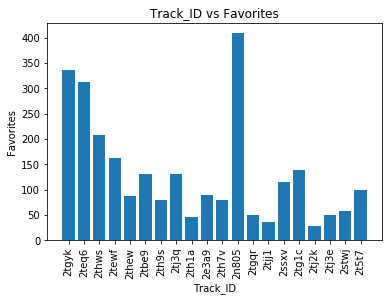

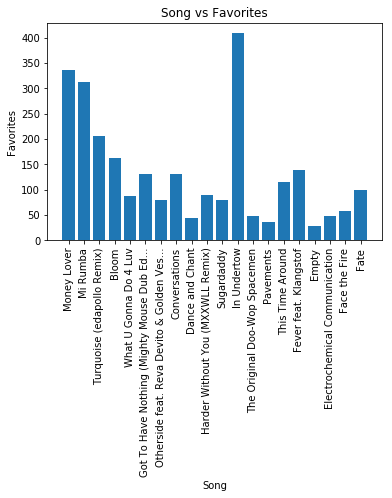

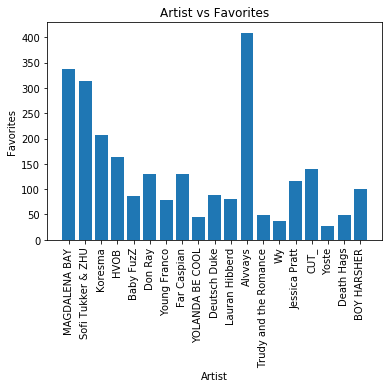

In [14]:
# print the rows and columns
rows, columns = data.shape
print("Number of rows: ", rows)
print("Number of columns: ", columns)

# drop the null values and print the head
data = data.dropna()
print(data.head())

# Encode the labels to numerics
labelEncoder = preprocessing.LabelEncoder()
# plot 3 columns
track_id = list(data['track_id'])
favorites = list(data['favorites'])
artist = list(data['artist'])
song = list(data['song'])
# making a copy
songc = song
artistc = artist

labelEncoder.fit(artist)
artist = labelEncoder.transform(artist)
labelEncoder.fit(song)
song = labelEncoder.transform(song)
data['artist'] = artist
data['song'] = song

#artist = [x.split(' ')[0] for x in artist]
#song = [x.split(' ')[0] for x in song]

# Plot # 01
plt.bar(track_id[:20], favorites[:20])
plt.xlabel('Track_ID')
plt.ylabel('Favorites')
plt.xticks(rotation=90)
plt.title('Track_ID vs Favorites')
plt.show()

# Plot # 02
plt.bar(songc[:20], favorites[:20])
plt.xlabel('Song')
plt.ylabel('Favorites')
plt.xticks(rotation=90)
plt.title('Song vs Favorites')
plt.show()

# Plot # 03
plt.bar(artistc[:20], favorites[:20])
plt.xlabel('Artist')
plt.ylabel('Favorites')
plt.xticks(rotation=90)
plt.title('Artist vs Favorites')
plt.show()

In [15]:
# Recommendation Engine
train = [(x["artist"], x["song"], x["favorites"]) for i, x in data.iterrows()]
test = [(x["artist"], x["song"]) for i, x in data.iterrows()]

# Training
xtrain = sc.parallelize(train)
model = ALS.train(xtrain, 2, seed=200)

# Testing/Predicting
xtest = sc.parallelize(test)
y_pred = model.predictAll(xtest)

preds = spark.createDataFrame(y_pred)
preds.createOrReplaceTempView("predictions")
predicted_ratings = list(preds.toPandas()["rating"])

# Evaluating using Mean Squared Error
mse = 0
for x in range(len(predicted_ratings)):
    diff = (predicted_ratings[x] - float(train[x][2])) ** 2
    mse = mse + diff
mse = mse / len(predicted_ratings)
print("MSE is: ", mse)


MSE is:  39474334.71608722


In [0]:
'''
    For the task of classification and clustering, we play around with another dataset.
    We use the Titanic dataset from the Kaggle dataset store.
'''
# read the dataset
data = pd.read_csv('train.csv')

In [17]:
# print the rows and columns
rows, columns = data.shape
print("Number of rows: ", rows)
print("Number of columns: ", columns)

# drop the null values and print the head
data = data.dropna()
print(data.head())


Number of rows:  891
Number of columns:  12
    PassengerId  0urvived  Pclass  ...     Fare  1abin  Embarked
1             2         1       1  ...  71.2833    185       1.0
3             4         1       1  ...  53.1000   1123       0.0
6             7         0       1  ...  51.8625    E46       0.0
10           11         1       3  ...  16.7000     G6       0.0
11           12         1       1  ...  26.5500   1103       0.0

[5 rows x 12 columns]


In [18]:
x = list(data[['Pclass', '0ex', 'Age', '0ib0p', 'Parch', 'Embarked']])
y = list(data[['0urvived']])

class_names, class_counts = np.unique(list(data["0urvived"]), return_counts=True)
print(class_names)
xtrain = []
xtest = []

for idx, row in data.iterrows():
    features = [row["Pclass"], row["0ex"], row["Age"], row["0ib0p"], row["Parch"], row["Embarked"]]
    label = row["0urvived"]
    xtrain.append(LabeledPoint(label, features))
    xtest.append(features)

# Training
trainer = sc.parallelize(xtrain)
model = LogisticRegressionWithLBFGS.train(trainer, iterations=10, numClasses=len(class_names))

# Testing and predicting
tester = sc.parallelize(xtest)
y_pred = model.predict(tester)

predictions = y_pred.map(lambda x: x).collect()

# Evaluating Model using Accuracy
count = 0
for x in range(len(xtrain)):
    if int(xtrain[x].label) == int(predictions[x]):
        count += 1
print("Accuracy is: ", (count / len(xtrain)))


[0 1]
Accuracy is:  0.7759562841530054


In [20]:
dataset = spark.read.csv("train.csv", inferSchema=True, header=True)
dataset.na.drop()
dataset.show(5)
# Now we perform the clustering.
train_cols = ['Pclass', '0ex', '0ib0p', 'Parch']
vec_data = VectorAssembler(inputCols=train_cols, outputCol="features").transform(dataset)
# Training
model = KMeans(k=2, seed=100).fit(vec_data.select('features'))
# Testing
predicted = model.transform(vec_data)
evaluator = ClusteringEvaluator(predictionCol="prediction")
print("Clustering Accuracy is: ", evaluator.evaluate(predicted))

+-----------+--------+------+--------------------+---+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|0urvived|Pclass|                Name|0ex| Age|0ib0p|Parch|          Ticket|   Fare|1abin|Embarked|
+-----------+--------+------+--------------------+---+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  0|22.0|    1|    0|       A/5 21171|   7.25| null|       0|
|          2|       1|     1|1umings, Mrs. Joh...|  1|38.0|    1|    0|        P1 17599|71.2833|  185|       1|
|          3|       1|     3|Heikkinen, Miss. ...|  1|26.0|    0|    0|0TON/O2. 3101282|  7.925| null|       0|
|          4|       1|     1|Futrelle, Mrs. Ja...|  1|35.0|    1|    0|          113803|   53.1| 1123|       0|
|          5|       0|     3|Allen, Mr. Willia...|  0|35.0|    0|    0|          373450|   8.05| null|       0|
+-----------+--------+------+--------------------+---+----+-----+-----+----------------+-------+-----+--